# UNDER CONSTRUCTION
- Normalization wrong for small test_duration and n_events
- Description wrong
- Jeffreys prior wrong
- Untested

# Description

This notebook calculates the Bayesian posterior distribution of the binomial single trial success probability, given the number of conducted tests ```n_trials``` and the number of successful tests ```n_successes``` out of these, using a uniform prior distribution.

This notebook produces a graph that tells you how much belief you can put into any of the possible single trial success probabilities between 0 (always fails) and 1 (always succeeds) after having done a test with ```n_trials``` trials of which ```n_successes``` were successful. This result depends on a so-called prior distribution that models your belief in different possible single trial success probabilities before the test. By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [66]:
test_duration = 1
n_events = 0

assert isinstance(test_duration, (int, float)) and test_duration > 0
assert isinstance(n_events, int) and n_events >= 0

# Evaluation

norm = 1.5812365703618966629032675480865958498581085634721


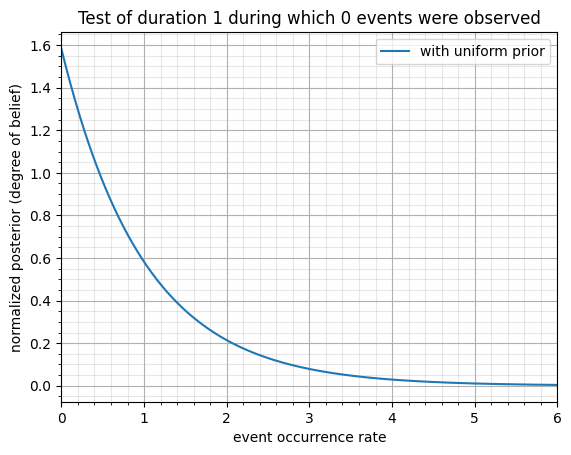

In [69]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_poisson_p(r_event, test_duration, n_events, prior):
    return mp.power(mp.mpf(r_event*test_duration), n_events) / mp.fac(n_events) * mp.exp(-r_event*test_duration) * prior(r_event, test_duration)

posterior_prob_poisson_p_vectorized = np.vectorize(posterior_prob_poisson_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_poisson_p_norm(test_duration, n_events, prior, bounds):
    mean = n_events / test_duration
    std_dev = n_events**0.5 / test_duration
    prescale = 1/posterior_prob_poisson_p(mean, test_duration, n_events, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
        
    return norm / prescale

r_plotmax = max(1, n_events)/test_duration + 5*max(1, n_events)**0.5/test_duration #mean+5*std_dev for n_events > 0
r = np.linspace(0, r_plotmax, 1001)

prior = lambda rate, duration: 1
posterior_probs = posterior_prob_poisson_p_vectorized(r, test_duration, n_events, prior) / integrate_posterior_prob_poisson_p_norm(test_duration, n_events, prior, [0, 10*e])
plt.plot(r, posterior_probs, label='with uniform prior')

print('norm = {}'.format(posterior_probs.sum() * r_plotmax/1001))

# prior = lambda p: (p*(1-p))**0.5
# posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials, n_successes, prior) / integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [0, 1])
# plt.plot(p, posterior_probs, label='with Jeffrey\'s prior')
# plt.plot(p, prior(p), label='Jeffrey\'s prior')

plt.gca().set_title('Test of duration {} during which {} events were observed'.format(test_duration, n_events))
plt.gca().set_xlabel('event occurrence rate')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([0, r_plotmax]); #change plot range here